# Changing to update the performance

0.8249563046192259 +/- 0.04366214002255289 



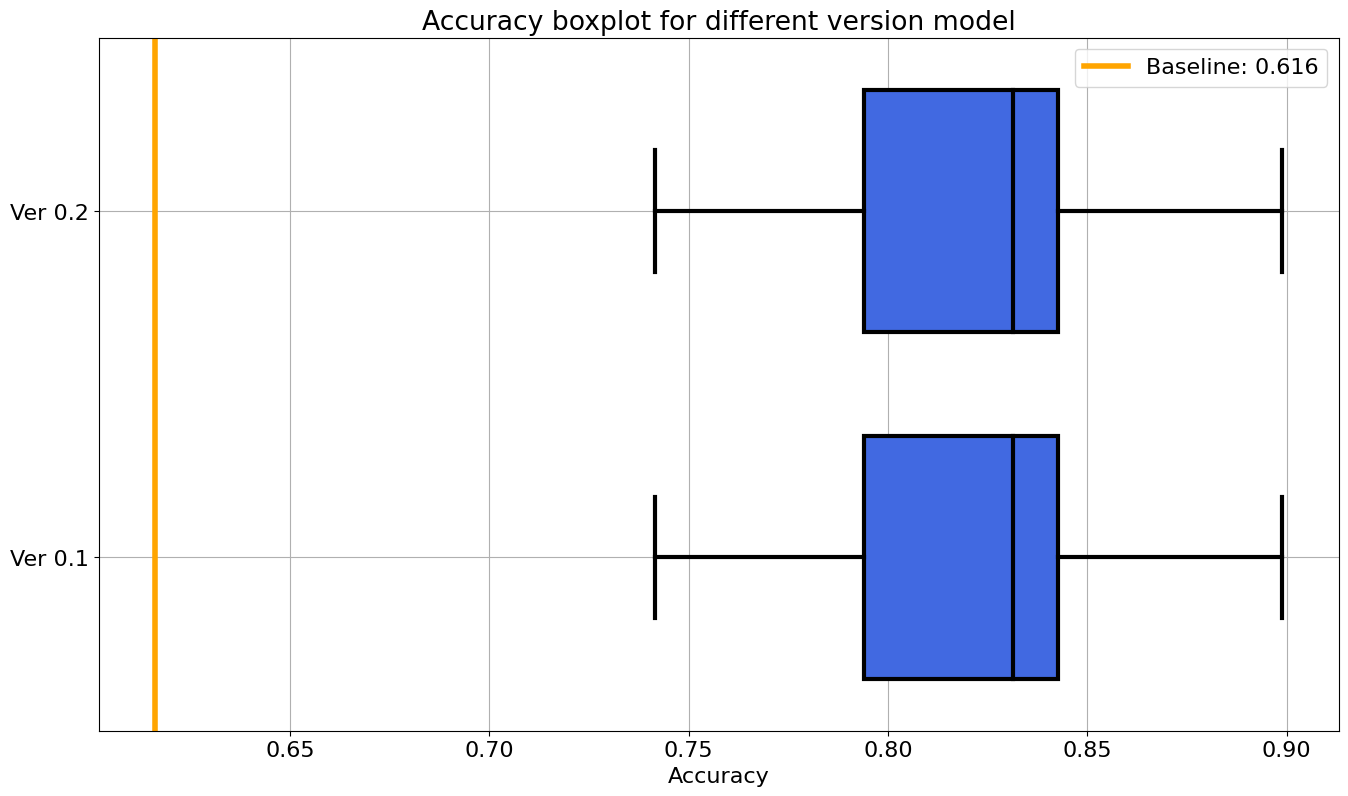

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


def ingest_data() -> pd.DataFrame():
    tr = pd.read_csv("../input/titanic/train.csv")
    te = pd.read_csv("../input/titanic/test.csv")

    tr["Source"] = "Training"
    te["Source"] = "Testing"

    return pd.concat((tr, te))


def feature_engineering0(input_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    to_be_dropped = ["Name", "Ticket", "Cabin", "Source"]
    source = input_df["Source"]
    df = input_df.drop(to_be_dropped, axis=1).copy()

    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Age"] = df["Age"].fillna(np.median(df["Age"].dropna()))
    df["Fare"] = df["Fare"].fillna(np.median(df["Fare"].dropna()))
    df["Embarked"] = df["Embarked"].fillna("S")

    df = pd.get_dummies(df, dtype=np.int64)
    return (df[source == "Training"], df[source == "Testing"])


def estimate_performance(train: pd.DataFrame) -> list:
    model = RandomForestClassifier(random_state=2024)
    Y = train.pop("Survived")
    scores = cross_val_score(model, train, Y, cv=10)
    print(np.mean(scores), "+/-", np.std(scores), "\n")
    return scores


previous = str(0.1)
version = str(0.2)
baseline = 549 / (549 + 342)

df = ingest_data()
train, test = feature_engineering0(df)
scores = estimate_performance(train)


old_performance = pd.DataFrame()

if os.path.isfile(f"performance_{previous}.csv"):
    old_performance = pd.read_csv(
        f"performance_{previous}.csv", dtype={"Version": str, "Performance": float}
    )

performance = pd.concat(
    (
        old_performance,
        pd.DataFrame({"Version": [version] * 10, "Performance": scores}),
    )
)
performance.to_csv(f"performance_{version}.csv", index=False)

input_data = [
    performance.loc[performance["Version"] == i, "Performance"]
    for i in performance["Version"].unique()
]


plt.rcParams["font.size"] = 16
plt.figure(figsize=(16, 9))
plt.title("Accuracy boxplot for different version model")
plt.axvline(baseline, color="orange", lw=4, label=f"Baseline: {round(baseline, 3)}")
input_data = [
    performance.loc[performance["Version"] == i, "Performance"]
    for i in performance["Version"].unique()
]

plt.boxplot(
    input_data,
    vert=False,
    widths=0.7,
    patch_artist=True,
    boxprops=dict(facecolor="royalblue", color="black", linewidth=3),
    whiskerprops=dict(color="black", linewidth=3),
    capprops=dict(color="black", linewidth=3),
    medianprops=dict(color="black", linewidth=3),
)

plt.xlabel("Accuracy")
plt.yticks(
    [i + 1 for i in range(len(performance["Version"].unique()))],
    [f"Ver {i}" for i in performance["Version"].unique()],
)
plt.grid()
plt.legend()
plt.savefig(f"Performance_{version}.png", dpi=300)